# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


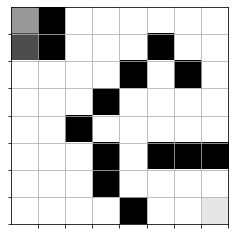

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [1]:
# Author: Stephen Owusu-Agyekum
# Date: 2024-04-15
# Version: V.2.1.0
# Description: This function implements the Q-training algorithm to train a model using reinforcement learning.

def qtrain(model, maze, **opt):
    # Exploration factor for epsilon-greedy strategy
    # This is to clarify the purpose of the global variable 'epsilon' for adjusting exploration factor.
    # And document the significance of 'epsilon' in controlling the exploration factor for the agent.

    global epsilon

    # Number of epochs for training
    # To specify the default number of training epochs if not provided.
    # And provide a default value to ensure the training runs with a reasonable number of epochs.

    n_epoch = opt.get('n_epoch', 15000)

    # Maximum memory capacity to store experiences
    # Set the default maximum memory capacity for storing experiences if not provided.
    # Define a default value to ensure the model has enough memory to store experiences during training.

    max_memory = opt.get('max_memory', 1000)

    # Maximum size of data used for training in each epoch
    # Define the default size of data used for training if not specified.
    # Specify a default value to control the amount of data used for training in each epoch.

    data_size = opt.get('data_size', 50)

    # Record the start time of training
    # We Capture the start time to measure the duration of the training process.
    # Document the action of recording the start time for later measurement.

    start_time = datetime.datetime.now()

    # Construct the environment/game from the provided maze represented as a numpy
    # Initialize the environment using the provided maze data.
    # Provide a clear explanation of the purpose of initializing the environment.

    qmaze = TreasureMaze(maze)

    # Initialize the experience replay object for storing game experiences
    # Set up the experience replay mechanism for model learning.
    # Document the action of initializing the experience replay object.

    experience = GameExperience(model, max_memory=max_memory)

    # History of win/lose game outcomes
    # Track the outcomes of each game for training evaluation.
    #  Clarify the purpose of the 'win_history' list in monitoring training progress.

    win_history = []

    # Size of the history window for win rate calculation
    # To define the size of the window used to calculate the win rate.
    # Specify the window size to ensure an appropriate evaluation period for win rate calculation.

    hsize = qmaze.maze.size//2

    # Current win rate
    # This is to initialize the win rate variable for monitoring training progress.
    # This is to document the initialization of the 'win_rate' variable.

    win_rate = 0.0 
    
    # Iterate over each epoch for training
    for epoch in range(n_epoch):
        # Reset epoch-specific variables
        # To prepare epoch-specific variables for each training iteration.
        # To document the resetting of variables to their initial state at the beginning of each epoch.

        loss = 0.0
        game_over = False
        n_episodes = 0
        
        # Randomly select a free cell as the starting point for the agent
        # This is to choose a random starting position for the agent within the maze.
        # And to clarify the action of randomly selecting the agent's starting position.

        Agent_cell = random.choice(qmaze.free_cells)

        # Reset the maze with the agent positioned at the chosen cell
        # To reset the environment for a new epoch with the agent at the chosen starting position.
        # To document the action of resetting the maze environment.

        qmaze.reset(Agent_cell)
        
        # Obtain the current state of the environment (envstate)
        # Capture the current state of the environment.
        # Document the action of obtaining the environment state for the agent.

        envstate = qmaze.observe()
        
        # Loop until the game is over
        while not game_over:
            # Obtain all valid actions the agent can take from the current state
            # Retrieve the valid actions the agent can perform.
            # Clarify the action of obtaining valid actions for the agent.

            valid_actions = qmaze.valid_actions()

            # If there are no valid actions, end the loop
            #  Handle the scenario where the agent has no valid actions.
            # Document the decision to exit the loop when there are no valid actions available.
           
            if not valid_actions:
                break 

            # Save the previous environment state
            # Store the previous environment state for learning.
            # Document the action of saving the previous state before taking an action.

            prev_envstate = envstate
            
            # Decide on the next action based on epsilon-greedy strategy
            # Determine the next action for the agent using an epsilon-greedy strategy.
            # Clarify the decision-making process for selecting the next action.

            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))
                            
            # Apply the selected action, obtain reward and new environment state
            # Execute the selected action and observe the outcome.
            # Document the action of applying the selected action and receiving feedback from the environment.

            envstate, reward, game_status = qmaze.act(action)

            # Check if the game is won or lost
            # Monitor the game status to determine if it's won or lost.
            # Document the action of checking the game status and recording wins/losses accordingly.

            if game_status == 'win':
                win_history.append(1)
                game_over = True 
            elif game_status == 'lose':
                win_history.append(0) 
                game_over = True  
            else:
                game_over = False
        
            # Store the episode in the Experience Replay Object for learning
            # To record the episode (state, action, reward, next state) for experience replay.
            # And to document the action of storing the episode in the experience replay memory.

            episode = [prev_envstate, action, reward, envstate, game_status]
            n_episodes += 1 
            experience.remember(episode)
            
            # Train neural network model and evaluate loss
            # Use experience replay to train the model and evaluate loss.
            # Clarify the training process and evaluation of model performance.

            inputs, targets = experience.get_data(data_size=data_size)
            History = model.fit(
                inputs, 
                targets, 
                epochs=20,
                batch_size=50,
                verbose=0
            ) 
            loss = model.evaluate(inputs, targets, verbose=0)  # Decision: Evaluate model performance.
            
        # Calculate win rate over the recent history   
        # Compute the win rate based on recent game outcomes.
        # Document the calculation of win rate for monitoring training progress.

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        
        # Print the epoch, loss, episodes, win count, and win rate for each epoch
        # Display training progress including epoch details, loss, and win rate.
        # Provide detailed feedback on training progress for monitoring and analysis.

        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t)) 
        
        # Check if the win rate is above a threshold and model passes completion check
        # Adjust exploration factor if win rate is high and check for completion criteria.
        # Document the decision-making process based on win rate and model completion.

        if win_rate > 0.9 : 
            epsilon = 0.05
        
        # Notify if the model achieves 100% win rate.
        # This help provide information about the achievement of 100% win rate and completion of training.
        # Provide feedback on significant milestones during training.

        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,)) 
            break 
    
    # Determine the total time for training
    # Measure the total duration of the training process.
    # Document the action of calculating the training duration.

    dt = datetime.datetime.now() - start_time 
    seconds = dt.total_seconds() 
    t = format_time(seconds)  
    
    # Print final training statistics
    # Display final training statistics including duration, epoch count, and memory size.
    # Provide a summary of the training process for evaluation and reporting.

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t)) 
    return seconds 

# Utility function for formatting time into human-readable format
def format_time(seconds):
    # If training duration is less than 400 seconds, return time in seconds with one decimal place.
    #  Format the training duration into a human-readable format.
    # Provide clear and concise time representation for better readability.

    if seconds < 400:
        s = float(seconds)
         
        return "%.1f seconds" % (s,) 
    # If training duration is less than 4000 seconds, return time in minutes with two decimal places.
    elif seconds < 4000: 
        m = seconds / 60.0
        
        return "%.2f minutes" % (m,) 
    # If training duration is greater than or equal to 4000 seconds, return time in hours with two decimal places.
    else:  
        h = seconds / 3600.0
    
        return "%.2f hours" % (h,)


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

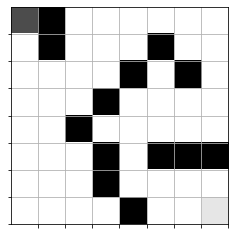

In [11]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [12]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0001 | Episodes: 135 | Win count: 0 | Win rate: 0.000 | time: 41.2 seconds
Epoch: 001/14999 | Loss: 0.0006 | Episodes: 134 | Win count: 0 | Win rate: 0.000 | time: 93.3 seconds
Epoch: 002/14999 | Loss: 0.0003 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 147.9 seconds
Epoch: 003/14999 | Loss: 0.0007 | Episodes: 10 | Win count: 1 | Win rate: 0.000 | time: 151.3 seconds
Epoch: 004/14999 | Loss: 0.0008 | Episodes: 33 | Win count: 2 | Win rate: 0.000 | time: 163.5 seconds
Epoch: 005/14999 | Loss: 0.0081 | Episodes: 14 | Win count: 3 | Win rate: 0.000 | time: 168.8 seconds
Epoch: 006/14999 | Loss: 0.0007 | Episodes: 4 | Win count: 4 | Win rate: 0.000 | time: 170.2 seconds
Epoch: 007/14999 | Loss: 0.0004 | Episodes: 149 | Win count: 4 | Win rate: 0.000 | time: 229.7 seconds
Epoch: 008/14999 | Loss: 0.0004 | Episodes: 103 | Win count: 5 | Win rate: 0.000 | time: 270.0 seconds
Epoch: 009/14999 | Loss: 0.0005 | Episodes: 42 | Win count: 6 | Win rate: 0.000 

Epoch: 080/14999 | Loss: 0.0005 | Episodes: 5 | Win count: 76 | Win rate: 1.000 | time: 17.38 minutes
Epoch: 081/14999 | Loss: 0.0006 | Episodes: 31 | Win count: 77 | Win rate: 1.000 | time: 17.57 minutes
Epoch: 082/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 78 | Win rate: 1.000 | time: 17.76 minutes
Epoch: 083/14999 | Loss: 0.0002 | Episodes: 9 | Win count: 79 | Win rate: 1.000 | time: 17.82 minutes
Epoch: 084/14999 | Loss: 0.0006 | Episodes: 33 | Win count: 80 | Win rate: 1.000 | time: 18.03 minutes
Epoch: 085/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 81 | Win rate: 1.000 | time: 18.16 minutes
Epoch: 086/14999 | Loss: 0.0007 | Episodes: 4 | Win count: 82 | Win rate: 1.000 | time: 18.17 minutes
Epoch: 087/14999 | Loss: 0.0006 | Episodes: 2 | Win count: 83 | Win rate: 1.000 | time: 18.18 minutes
Epoch: 088/14999 | Loss: 0.0002 | Episodes: 22 | Win count: 84 | Win rate: 1.000 | time: 18.25 minutes
Epoch: 089/14999 | Loss: 0.0005 | Episodes: 35 | Win count: 85 | Win rate: 1.

1238.070556

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

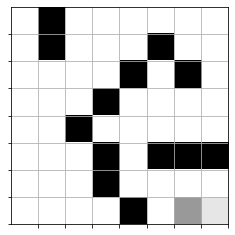

In [14]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

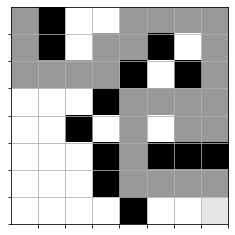

In [16]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)